In [ ]:
import matplotlib.pyplot as plt
import torchvision
import torch

# Loading Data

In [2]:
device = torch.device("cuda")

In [16]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

data =  torchvision.datasets.CIFAR100(root='./CIFAR-100', train=True, transform=transform, download=True)
test_data =  torchvision.datasets.CIFAR100(root='./CIFAR-100', train=False, transform=transform, download=True)

each imag is (3, 32, 32) with 100 labels

19 29 0 11 1 86 90 28 23 
 torch.Size([3, 32, 32])


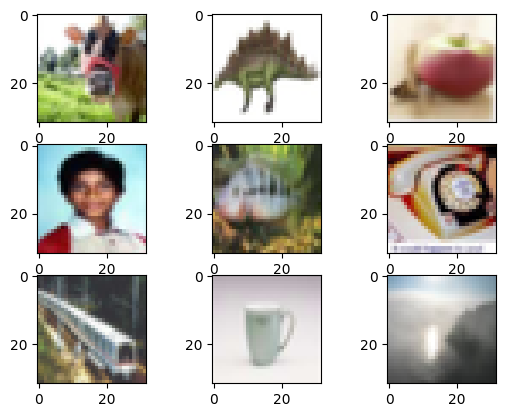

In [15]:
fig, axes = plt.subplots(3, 3)
i = 0
for img, label in data:

    # print(img[1][10])

    axes[i//3][i%3].imshow(img.permute(1, 2, 0))
    
    # normalize = torchvision.transforms.Normalize((0.5, ), (0.5, ))
    # img = normalize(img)

    # axes[1].imshow(img.permute(1, 2, 0))
    
    print(label, end=" ")
    if i == 8: break
    i += 1
    
print("\n", img.shape)

#### colour values are between 0 and 1
<!-- #### and normalizing ruins the image hence we wont do it -->

### Making the network

## training

In [5]:
def test_test(model):

    test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True, pin_memory=True)
    model.eval()
    correct = 0
    total = 0
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        correct += torch.sum(torch.argmax(out, dim=1) == y)
        total += len(y)
    print(f"Test Accuracy: {correct*100/total:.2f}%")

def test_train(model):

    test_loader = torch.utils.data.DataLoader(data, batch_size=128, shuffle=True, pin_memory=True)
    model.eval()
    correct = 0
    total = 0
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        correct += torch.sum(torch.argmax(out, dim=1) == y)
        total += len(y)
    print(f"Train Accuracy: {correct*100/total:.2f}%")

In [6]:
batch_size = 128
epochs = 50
lr = 0.001

loss_fn = torch.nn.CrossEntropyLoss()

In [7]:
def train(sequntial_model, epoch=epochs):
    model = sequntial_model.to(device)

    # optimizer_seq = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer_seq = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer_seq, step_size=30, gamma=0.5)
    train_data  = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, pin_memory=True)

    for i in range(epoch):
        model.train()
        total_loss = 0
        for x, y in train_data:
            x, y = x.to(device), y.to(device)

            optimizer_seq.zero_grad()
            out = model(x)

            loss = loss_fn(out, y)
            # Cross Entropy loss does the summing itself so no need
            # loss = torch.sum(loss_fn(out, y))

            # print(loss, torch.sum(loss))
            # output: tensor(3.0177, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(3.0177, device='cuda:0', grad_fn=<SumBackward0>)
            # break

            # still doing sum of one number will not change the loss itself 
            # it will change the graph used for backpropagation but still it wont have any effect on the training
            loss.backward()
            optimizer_seq.step()
            total_loss += loss  
        
        scheduler.step()
        if i%10 == 9:
            print(f"Epoch: {i+1}, Loss: {total_loss}") 

    test_train(model)
    test_test(model)

### Experimenting

In [ ]:
sequntial_model_attempt1 = torch.nn.Sequential(

    torch.nn.Conv2d(3, 32, 3, bias=True),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.ReLU(),
    torch.nn.Dropout2d(0.25),

    torch.nn.Conv2d(32, 64, 4, bias=True),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.ReLU(),
    torch.nn.Dropout2d(0.25),
    
    torch.nn.Flatten(),
    torch.nn.Linear(6*6*64, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout1d(0.5),

    torch.nn.Linear(512, 100)
    )

train(sequntial_model_attempt1)

Epoch: 10, Loss: 1423.23095703125
Epoch: 20, Loss: 1308.3636474609375
Epoch: 30, Loss: 1240.938232421875
Epoch: 40, Loss: 1170.92724609375
Epoch: 50, Loss: 1140.74462890625
Epoch: 60, Loss: 1119.972412109375
Epoch: 70, Loss: 1084.9385986328125
Epoch: 80, Loss: 1071.8841552734375
Epoch: 90, Loss: 1057.1239013671875
Epoch: 100, Loss: 1055.2979736328125
Train Accuracy: 97.61%
Test Accuracy: 34.14%


overfitting seems to be the problem<br><br>
Retrying after decreasing number of parameters

In [ ]:
sequntial_model_attempt2 = torch.nn.Sequential(
    torch.nn.Conv2d(3, 32, 3, bias=True),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.ReLU(),
    torch.nn.Dropout2d(0.25),

    torch.nn.Conv2d(32, 64, 4, bias=True),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.ReLU(),
    torch.nn.Dropout2d(0.25),
    
    torch.nn.Flatten(),

    torch.nn.Linear(6*6*64, 100)
    )

train(sequntial_model_attempt2, epoch=100)

Epoch: 10, Loss: 901.6660766601562
Epoch: 20, Loss: 753.7998657226562
Epoch: 30, Loss: 679.3723754882812
Epoch: 40, Loss: 600.22216796875
Epoch: 50, Loss: 576.8128051757812
Epoch: 60, Loss: 558.2508544921875
Epoch: 70, Loss: 530.496826171875
Epoch: 80, Loss: 522.04443359375
Epoch: 90, Loss: 513.0552978515625
Epoch: 100, Loss: 501.54443359375
Train Accuracy: 88.08%
Test Accuracy: 34.29%


In [ ]:
sequntial_model_attempt3 = torch.nn.Sequential(
    torch.nn.Conv2d(3, 16, 3, bias=True),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.ReLU(),
    torch.nn.Dropout2d(0.25),

    torch.nn.Conv2d(16, 32, 4, bias=True),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.ReLU(),
    torch.nn.Dropout2d(0.25),
    
    torch.nn.Flatten(),

    torch.nn.Linear(6*6*32, 100)
    )

train(sequntial_model_attempt3)

Epoch: 10, Loss: 1106.7060546875
Epoch: 20, Loss: 1007.1998901367188
Epoch: 30, Loss: 960.1782836914062
Epoch: 40, Loss: 915.304931640625
Epoch: 50, Loss: 904.365234375
Train Accuracy: 59.22%
Test Accuracy: 33.30%


In [ ]:
sum(p.numel() for p in sequntial_model_attempt3.parameters() if p.requires_grad)

123972

In [ ]:
sequntial_model_attempt4 = torch.nn.Sequential(
    torch.nn.Conv2d(3, 8, 5, bias=True),
    torch.nn.MaxPool2d(4, 4),
    torch.nn.ReLU(),
    torch.nn.Dropout2d(0.25),

    torch.nn.Flatten(),

    torch.nn.Linear(7*7*8, 100),
    )

# 39k parameters

train(sequntial_model_attempt4)

Epoch: 10, Loss: 1270.3975830078125
Epoch: 20, Loss: 1215.59765625
Epoch: 30, Loss: 1194.6181640625
Epoch: 40, Loss: 1170.78173828125
Epoch: 50, Loss: 1165.4248046875
Train Accuracy: 39.38%
Test Accuracy: 29.84%


just reducing the model complexity is not the solution to overfitting, trying batch normalization

In [9]:
sequntial_model_attempt5 = torch.nn.Sequential(

    torch.nn.Conv2d(3, 32, 3, bias=True),
    torch.nn.BatchNorm2d(32),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.ReLU(),
    torch.nn.Dropout2d(0.25),

    torch.nn.Conv2d(32, 64, 4, bias=True),
    torch.nn.BatchNorm2d(64),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.ReLU(),
    torch.nn.Dropout2d(0.25),
    
    torch.nn.Flatten(),
    torch.nn.Linear(6*6*64, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout1d(0.5),

    torch.nn.Linear(512, 100)
    )

train(sequntial_model_attempt5, epoch=100)

Epoch: 10, Loss: 1436.0009765625
Epoch: 20, Loss: 1361.2618408203125
Epoch: 30, Loss: 1320.713134765625
Epoch: 40, Loss: 1279.1484375
Epoch: 50, Loss: 1249.451171875
Epoch: 60, Loss: 1217.887939453125
Epoch: 70, Loss: 1185.0340576171875
Epoch: 80, Loss: 1164.9498291015625
Epoch: 90, Loss: 1148.9718017578125
Epoch: 100, Loss: 1130.6016845703125
Train Accuracy: 87.30%
Test Accuracy: 41.07%


adding batchnorm1d after the 1st hidden layer as well

In [ ]:
sequntial_model_attempt6 = torch.nn.Sequential(

    torch.nn.Conv2d(3, 32, 3, bias=True),
    torch.nn.BatchNorm2d(32),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.ReLU(),
    torch.nn.Dropout2d(0.25),

    torch.nn.Conv2d(32, 64, 4, bias=True),
    torch.nn.BatchNorm2d(64),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.ReLU(),
    torch.nn.Dropout2d(0.25),
    
    torch.nn.Flatten(),
    torch.nn.Linear(6*6*64, 512),
    ###
    torch.nn.BatchNorm1d(512),
    ###
    torch.nn.ReLU(),
    torch.nn.Dropout1d(0.5),

    torch.nn.Linear(512, 100)
    )

train(sequntial_model_attempt6, epoch=100)

Epoch: 10, Loss: 1308.46533203125
Epoch: 20, Loss: 1166.0462646484375
Epoch: 30, Loss: 1087.508056640625
Epoch: 40, Loss: 1010.963623046875
Epoch: 50, Loss: 997.5079345703125
Epoch: 60, Loss: 981.43310546875
Epoch: 70, Loss: 959.8558959960938
Epoch: 80, Loss: 943.7411499023438
Epoch: 90, Loss: 950.6099853515625
Epoch: 100, Loss: 938.8417358398438
Train Accuracy: 99.89%
Test Accuracy: 41.31%


same network but lower epochs

In [11]:
sequntial_model_attempt7 = torch.nn.Sequential(

    torch.nn.Conv2d(3, 32, 3, bias=True),
    torch.nn.BatchNorm2d(32),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.ReLU(),
    torch.nn.Dropout2d(0.25),

    torch.nn.Conv2d(32, 64, 4, bias=True),
    torch.nn.BatchNorm2d(64),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.ReLU(),
    torch.nn.Dropout2d(0.25),
    
    torch.nn.Flatten(),
    torch.nn.Linear(6*6*64, 512),
    ###
    torch.nn.BatchNorm1d(512),
    ###
    torch.nn.ReLU(),
    torch.nn.Dropout1d(0.5),

    torch.nn.Linear(512, 100)
    )

train(sequntial_model_attempt7, epoch=10)

Epoch: 10, Loss: 1308.9451904296875
Train Accuracy: 60.65%
Test Accuracy: 39.69%


trying batch norm on a simpler network (attempt 2)

In [13]:
sequntial_model_attempt8 = torch.nn.Sequential(
    torch.nn.Conv2d(3, 32, 3, bias=True),
    torch.nn.BatchNorm2d(32),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.ReLU(),
    torch.nn.Dropout2d(0.25),

    torch.nn.Conv2d(32, 64, 4, bias=True),
    torch.nn.BatchNorm2d(64),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.ReLU(),
    torch.nn.Dropout2d(0.25),
    
    torch.nn.Flatten(),

    torch.nn.Linear(6*6*64, 100)
    )

train(sequntial_model_attempt8, epoch=20)

Epoch: 10, Loss: 880.7256469726562
Epoch: 20, Loss: 723.202880859375
Train Accuracy: 71.10%
Test Accuracy: 40.45%


In [ ]:
sequntial_model_gpt = torch.nn.Sequential(
    # First conv block
    torch.nn.Conv2d(3, 32, 3, padding=1),
    torch.nn.BatchNorm2d(32),
    torch.nn.ReLU(),
    torch.nn.Conv2d(32, 32, 3, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.Dropout2d(0.25),
    
    # Second conv block  
    torch.nn.Conv2d(32, 64, 3, padding=1),
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(),
    torch.nn.Conv2d(64, 64, 3, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.Dropout2d(0.25),
    
    # Third conv block
    torch.nn.Conv2d(64, 128, 3, padding=1),
    torch.nn.BatchNorm2d(128),
    torch.nn.ReLU(),
    torch.nn.Conv2d(128, 128, 3, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.Dropout2d(0.25),
    
    # Dense layers
    torch.nn.Flatten(),
    torch.nn.Linear(128 * 4 * 4, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(256, 100)
)

train(sequntial_model_gpt)

Epoch: 10, Loss: 1227.6910400390625
Epoch: 20, Loss: 1074.7119140625
Epoch: 30, Loss: 989.4529418945312
Epoch: 40, Loss: 895.714111328125
Epoch: 50, Loss: 848.1798706054688
Epoch: 60, Loss: 814.020751953125
Epoch: 70, Loss: 766.2198486328125
Epoch: 80, Loss: 746.2882690429688
Epoch: 90, Loss: 727.5650634765625
Epoch: 100, Loss: 706.1170043945312
Train Accuracy: 69.73%
Test Accuracy: 46.31%



Initally used very high Learning rate 0.1 (while using adam)<br>
Keep learning rate low then go up to experiment <br><br>

When i did this it lead to very high gradients, and due to the small batch size one class must be in majority <br>so after the 1st epoch the model learns to always predict that same class which leads to a sudden drop in loss for the first epoch but stops after that and ends up giving 1% acurracy for both train and test set<br><br>